# Telco Customer Churn

<p style='text-align: justify;'>
Customer churn is a major problem for many industries. Customer churn happens when customers decide to not continue purchasing products or services from an organization and end their association. It is an integral parameter for all the organizations since losing customers requires gaining new customers to replace them, and acquiring a new customer could cost almost 10 times more than retaining an existing one. Therefore, customer churn can prove to be a roadblock for an exponentially growing organization and a retention strategy should be decided in order to avoid an increase in customer churn rates.
</p>

Our goal is to identify some patterns between churned customers and see if we can successfully detect and prevent churn using Machine Learning.

## *Table of Contents*

- [*1. Introduction*](#introduction)
    - [*1.1. Libraries*](#libraries)
    - [*1.2. Notebook Settings*](#notebook_settings)
    - [*1.3. Data Collection*](#data_collection)
- [*2. Data Cleansing*](#data_cleansing)
    - [*2.1. Target Variable*](#target_variable)
    - [*2.2. Data Features*](#data_features)
- [*3. Exploratory Data Analysis*](#eda)
    - [*3.1. Target Variable Distribution*](#target_variable_distribution)
    - [*3.2. Feature Distributions (vs Target Variable)*](#feature_distributions)
- [*4. Data Preprocessing*](#data_preprocessing)
    - [*4.1. One-Hot Encoding*](#ohe)
    - [*4.2. Train Test Split*](#train_test_split)
- [*5. Feature Engineering*](#feature_engineering)
    - [*5.1. Feature Transformation*](#feature_transformation)
    - [*5.2. Feature Scaling*](#feature_scaling)
    - [*5.3. Handle Class Imbalance*](#handle_class_imbalance)
- [*6. Modeling*](#modeling)
    - [*6.1. Cross Validation*](#cross_validation)
    - [*6.2. GridSearchCV*](#grid_search_cv)
    - [*6.3. Predictions (on test set)*](#predictions)
- [*7. Conclusion*](#conclusion)

---

## Introduction <a class='anchor' id='introduction'></a>

### *Libraries* <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

import scipy.stats.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import shapiro, boxcox

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

### *Notebook Settings* <a class='anchor' id='notebook_settings'></a>

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### *Data Collection* <a class='anchor' id='data_collection'></a>

- The dataset were acquired from [kaggle](https://www.kaggle.com/blastchar/telco-customer-churn)

##### *Read the data*

In [3]:
df = pd.read_csv('./data/telco_customer_churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Cleansing <a class='anchor' id='data_cleansing'></a>

- Before we proceed with the next steps, we need first to clean our data

### *Target Variable* <a class='anchor' id='target_variable'></a>

- Our target variable is the column `Churn`
- As we see, the values in this column are in `object` format
- We will convert these values to numeric

##### *Convert target variable to numerical*

In [7]:
df['Churn'] = df['Churn'].apply(lambda x: 0 if x.strip().lower() == 'no' else 1)

### *Data Features* <a class='anchor' id='data_features'></a>

- The column `TotalCharges`, contains the amount of total charges per customer in euros (€)
- However, even though it contains numerical data, they appear as `object` type
- Therefore, we will change the type of this column and convert its values to numeric

##### *Convert `TotalCharges` to numerical*

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce', downcast='float')

##### *Check for any nan values*

In [9]:
df.TotalCharges.isna().sum()

11

##### *Drop those 11 nan values*

In [10]:
df = df.dropna(subset=['TotalCharges'])

##### *Handle `PaymentMethod` column*

In [11]:
df.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

- As we see, some of the payment methods are characterized as *automatic*
- Therefore, we will create a new binary feature to distinguish between automatic and non-automatic payment methods

##### *Create new binary feature for automatic payment methods*

In [12]:
# create the new binary feature
df['auto_PaymentMethod'] = df['PaymentMethod'].apply(lambda x: 0 if 'automatic' not in x.strip().lower() else 1)

# remove the text "(automatic)" from the initial column
df['PaymentMethod'] = df['PaymentMethod'].apply(lambda x: x.split(' (')[0])

In [13]:
df.PaymentMethod.value_counts()

Electronic check    2365
Mailed check        1604
Bank transfer       1542
Credit card         1521
Name: PaymentMethod, dtype: int64

In [14]:
df.auto_PaymentMethod.value_counts()

0    3969
1    3063
Name: auto_PaymentMethod, dtype: int64

In [15]:
df[['PaymentMethod', 'auto_PaymentMethod']].head()

,PaymentMethod,auto_PaymentMethod
0,Electronic check,0
1,Mailed check,0
2,Mailed check,0
3,Bank transfer,1
4,Electronic check,0


##### *Handle `InternetService` column*

In [16]:
df.InternetService.value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

- The `InternetService` column contains information about the type of Internet service provided to each customer
- We will parse this information into 3 separate binary columns, like we did with `auto_PaymentMethod` above

##### *Create binary features for the services provided to each customer*

In [17]:
# internet service (in general)
df['InternetService_yn'] = df['InternetService'].apply(lambda x: 0 if x.strip().lower() == 'no' else 1)

# DSL internet service
df['DSL_yn'] = df['InternetService'].apply(lambda x: 1 if x.strip().lower() == 'dsl' else 0)

# Fiber optic internet service
df['Fiber_yn'] = df['InternetService'].apply(lambda x: 1 if x.strip().lower() == 'fiber optic' else 0)

In [18]:
df[['InternetService', 'InternetService_yn', 'DSL_yn', 'Fiber_yn']].iloc[70:80]

,InternetService,InternetService_yn,DSL_yn,Fiber_yn
70,DSL,1,1,0
71,No,0,0,0
72,Fiber optic,1,0,1
73,No,0,0,0
74,DSL,1,1,0
75,Fiber optic,1,0,1
76,DSL,1,1,0
77,DSL,1,1,0
78,DSL,1,1,0
79,No,0,0,0


##### *Handle the rest of the columns*

In [19]:
rest = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in rest:
    print(f'{col}')
    print(f'{df[col].value_counts()}', end='\n\n')

MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64

OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64

OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64

DeviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64

TechSupport
No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64

StreamingTV
No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64

StreamingMovies
No                     2781
Yes                    2731
No internet service    1520
Name: StreamingMovies, dtype: int64



- There are already columns containing information for whether a customer has a phone service and/or an internet service
- Therefore, for the columns above, we will create new binary features for whether a customer has any of the folllowing services

    
##### *Create binary features for the rest of the services*

In [20]:
for col in rest:
    df[f'{col}_yn'] = df[col].apply(lambda x: 1 if x.strip().lower() == 'yes' else 0)

In [21]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,auto_PaymentMethod,InternetService_yn,DSL_yn,Fiber_yn,MultipleLines_yn,OnlineSecurity_yn,OnlineBackup_yn,DeviceProtection_yn,TechSupport_yn,StreamingTV_yn,StreamingMovies_yn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.850000,0,0,1,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.500000,0,0,1,1,0,0,1,0,1,0,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.150002,1,0,1,1,0,0,1,1,0,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.30,1840.750000,0,1,1,1,0,0,1,0,1,1,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.649994,1,0,1,0,1,0,0,0,0,0,0,0


##### *Save the cleaned data*

In [22]:
df.to_csv('./data/telco_customer_churn_cleaned.csv', index=False)

## EDA <a class='anchor' id='eda'></a>

- In this section, we analyze the data using visual techniques
- Specifically, we will try to understand the relationship between different features and our target variable
- We will look for trends, patterns and common characteristics between customers to find interesting insights

### *Target Variable Distribution* <a class='anchor' id='target_variable_distribution'></a>

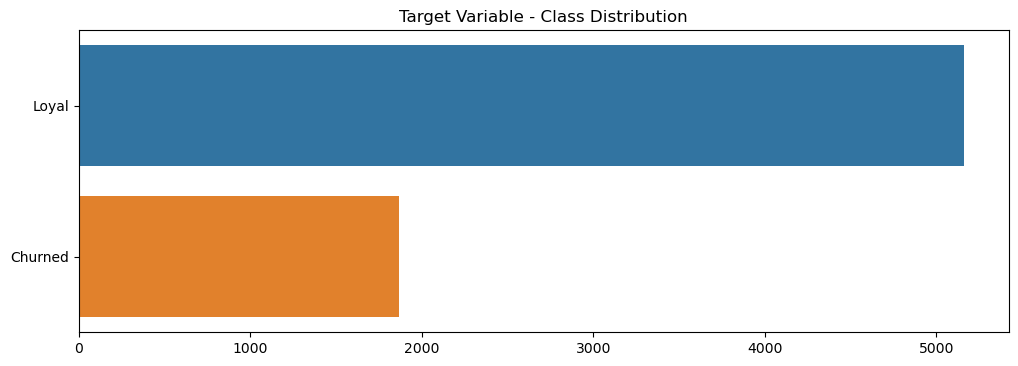

				 26.6% of the customers churned within the last month.


In [23]:
# create figure
plt.figure(figsize=(12,4), dpi=100, facecolor='white')

# plot
sns.countplot(data=df, y=df.Churn)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks(ticks=[0,1], labels=['Loyal', 'Churned'])
plt.title('Target Variable - Class Distribution')
plt.savefig('./images/class_distribution.svg')
plt.show()

print(f'\t\t\t\t {df.Churn.sum() / len(df) * 100:.3}% of the customers churned within the last month.')

- According to the graph, approx. 1 out of 4 customers left the company within the last month

### *Feature Distributions (vs Target Variable)* <a class='anchor' id='feature_distributions'></a>

##### *Plot demographics*

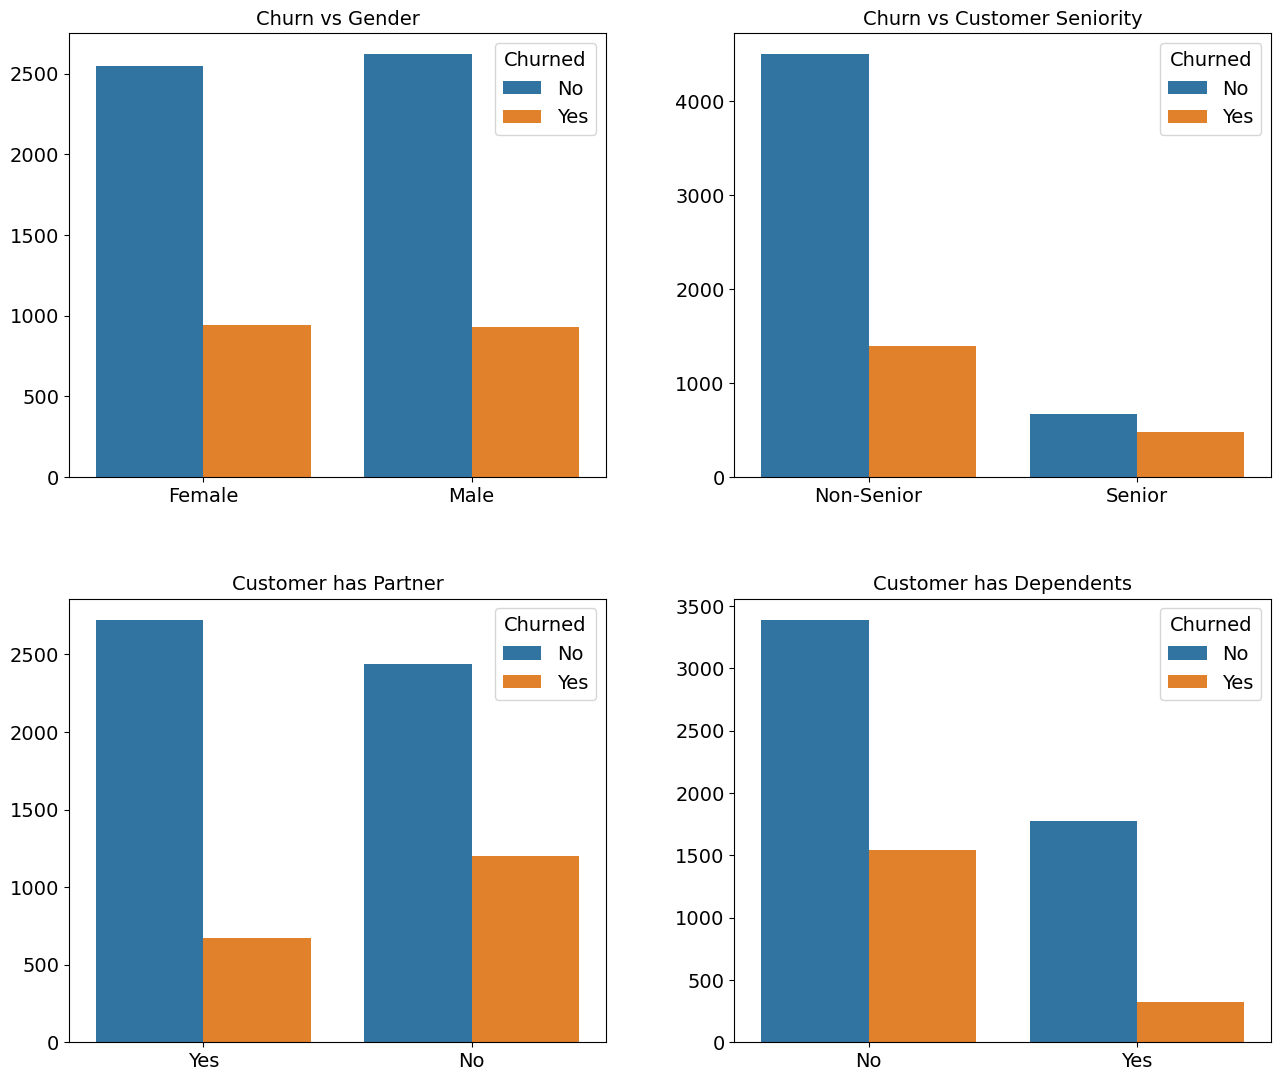

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(14,12), dpi=100, facecolor='white')

sns.countplot(x='gender', hue='Churn', data=df, ax=ax[0,0])
ax[0,0].set_xlabel(None)
ax[0,0].set_ylabel(None)
ax[0,0].tick_params(axis='both', which='major', labelsize=14)
ax[0,0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,0].set_title('Churn vs Gender', fontsize=14)

sns.countplot(x=df['SeniorCitizen'], hue='Churn', data=df, ax=ax[0,1])
ax[0,1].set_xlabel(None)
ax[0,1].set_ylabel(None)
ax[0,1].set_xticklabels(['Non-Senior', 'Senior'], fontsize=14)
ax[0,1].tick_params(axis='y', which='major', labelsize=14)
ax[0,1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,1].set_title('Churn vs Customer Seniority', fontsize=14)

sns.countplot(x='Partner', hue='Churn', data=df, ax=ax[1,0])
ax[1,0].set_xlabel(None)
ax[1,0].set_ylabel(None)
ax[1,0].tick_params(axis='both', which='major', labelsize=14)
ax[1,0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,0].set_title('Customer has Partner', fontsize=14)

sns.countplot(x='Dependents', hue='Churn', data=df, ax=ax[1,1])
ax[1,1].set_xlabel(None)
ax[1,1].set_ylabel(None)
ax[1,1].tick_params(axis='both', which='major', labelsize=14)
ax[1,1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,1].set_title('Customer has Dependents', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/demographics.svg')
fig.show()

- According to the graphs, churn is not a matter of gender
- However, non-senior customers and customers who don't have partners or dependents are more likely to churn

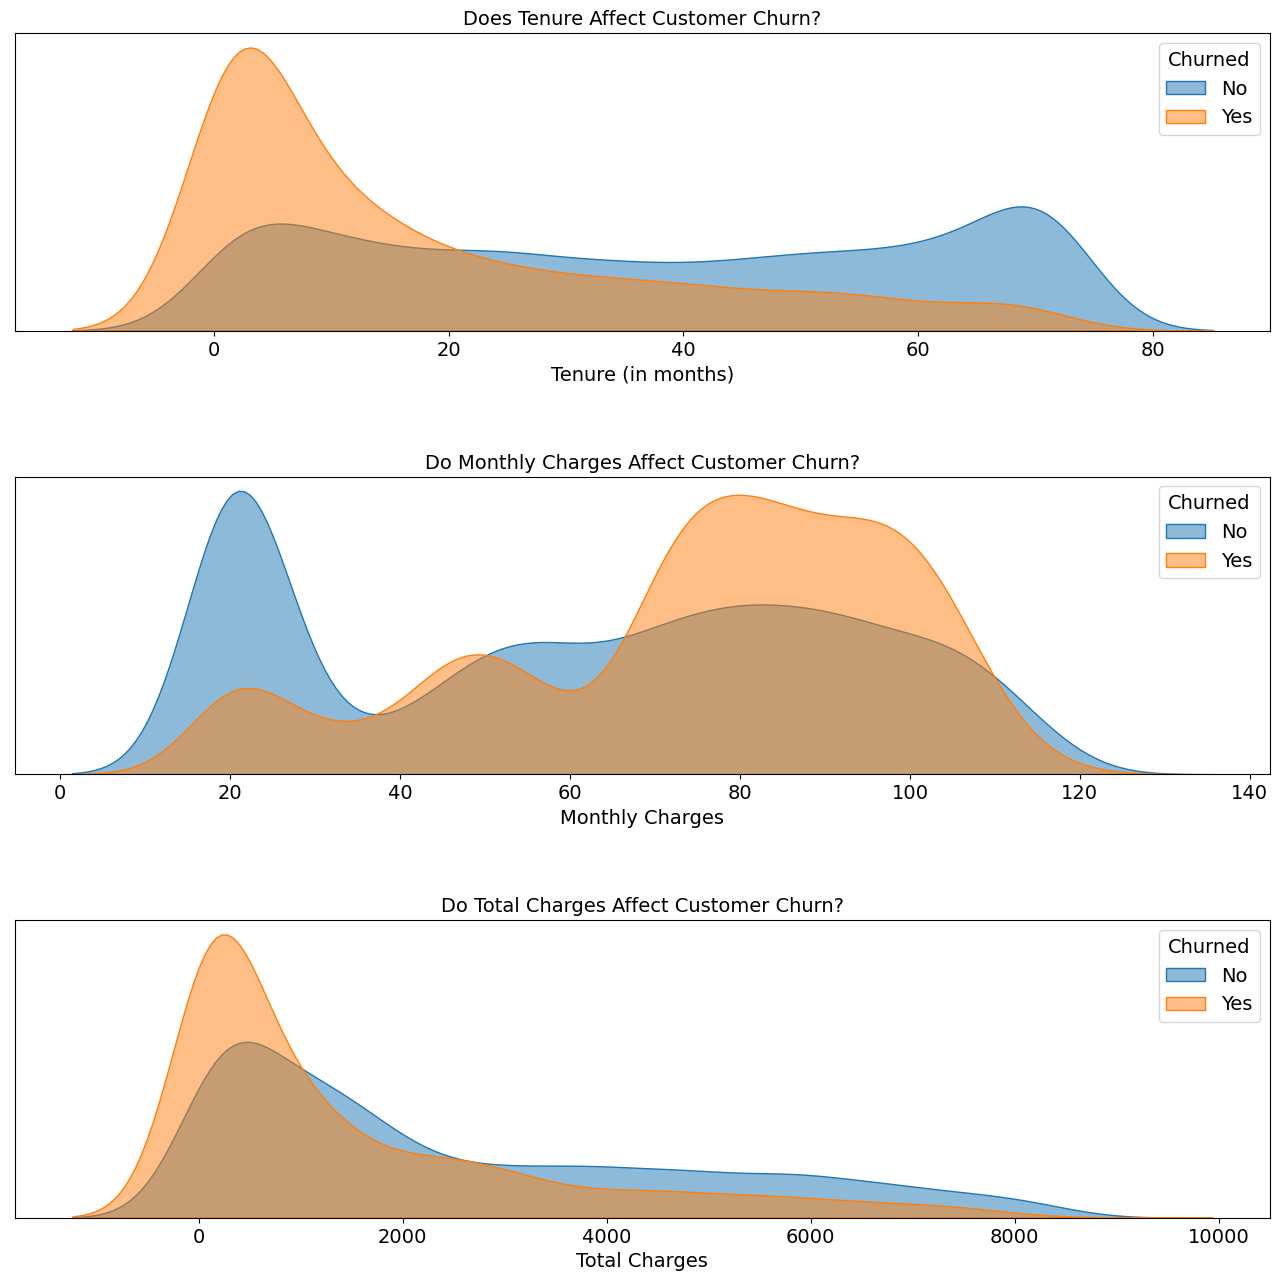

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(14,14), dpi=100, facecolor='white')

sns.kdeplot(df[df['Churn'] == 0]['tenure'], shade=True, alpha=0.5, label='No', ax=ax[0])
sns.kdeplot(df[df['Churn'] == 1]['tenure'], shade=True, alpha=0.5, label='Yes', ax=ax[0])
ax[0].set_xlabel('Tenure (in months)', fontsize=14)
ax[0].set_ylabel(None)
ax[0].set_yticks([])
ax[0].tick_params(axis='x', which='major', labelsize=14)
ax[0].legend(title='Churned', title_fontsize=14, fontsize=14)
ax[0].set_title('Does Tenure Affect Customer Churn?', fontsize=14)

sns.kdeplot(df[df['Churn'] == 0]['MonthlyCharges'], shade=True, alpha=0.5, label='No', ax=ax[1])
sns.kdeplot(df[df['Churn'] == 1]['MonthlyCharges'], shade=True, alpha=0.5, label='Yes', ax=ax[1])
ax[1].set_xlabel('Monthly Charges', fontsize=14)
ax[1].set_ylabel(None)
ax[1].set_yticks([])
ax[1].tick_params(axis='x', which='major', labelsize=14)
ax[1].legend(title='Churned', title_fontsize=14, fontsize=14)
ax[1].set_title('Do Monthly Charges Affect Customer Churn?', fontsize=14)

sns.kdeplot(df[df['Churn'] == 0]['TotalCharges'], shade=True, alpha=0.5, label='No', ax=ax[2])
sns.kdeplot(df[df['Churn'] == 1]['TotalCharges'], shade=True, alpha=0.5, label='Yes', ax=ax[2])
ax[2].set_xlabel('Total Charges', fontsize=14)
ax[2].set_ylabel(None)
ax[2].set_yticks([])
ax[2].tick_params(axis='x', which='major', labelsize=14)
ax[2].legend(title='Churned', title_fontsize=14, fontsize=14)
ax[2].set_title('Do Total Charges Affect Customer Churn?', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/kde_plots.svg')
fig.show()

- Seems that recent clients (smaller tenure) are more likely to churn
- Moreover, clients with higher monthly charges are more likely to churn, whereas total charges don't seem to be a reason for customers to churn

##### *Plot internet services provided*

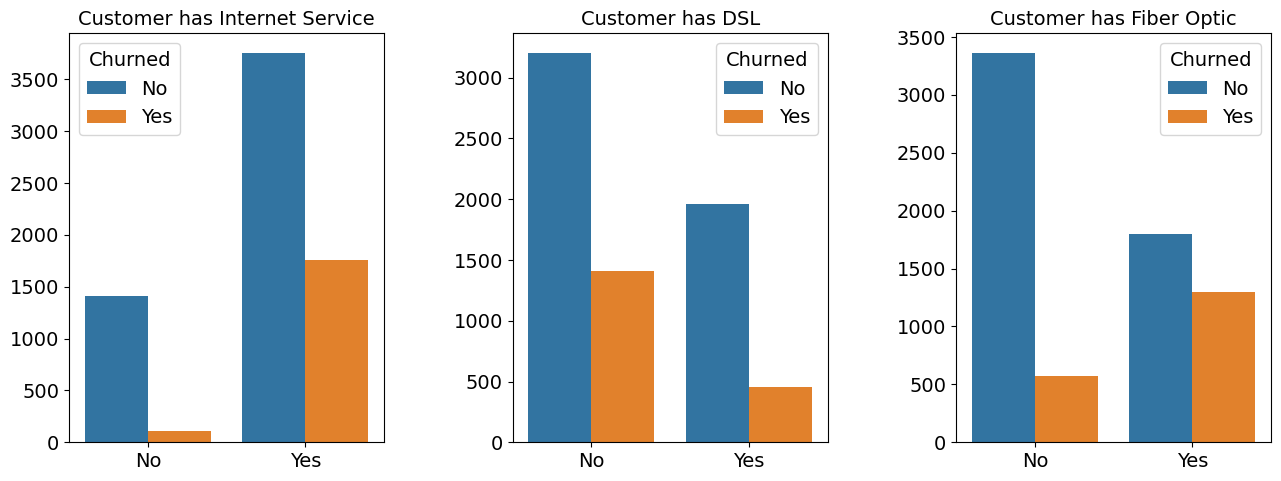

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(14,6), dpi=100, facecolor='white')

sns.countplot(x='InternetService_yn', hue='Churn', data=df, ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0].set_title('Customer has Internet Service', fontsize=14)

sns.countplot(x='DSL_yn', hue='Churn', data=df, ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=14)
ax[1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1].set_title('Customer has DSL', fontsize=14)

sns.countplot(x='Fiber_yn', hue='Churn', data=df, ax=ax[2])
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)
ax[2].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[2].set_title('Customer has Fiber Optic', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/internet_services.svg')
fig.show()

- Customers with Internet Service are more prone to churn
- Customers with fiber optic are, also, more likely to churn, in contrast with those with a DSL connection

##### *Plot other services*

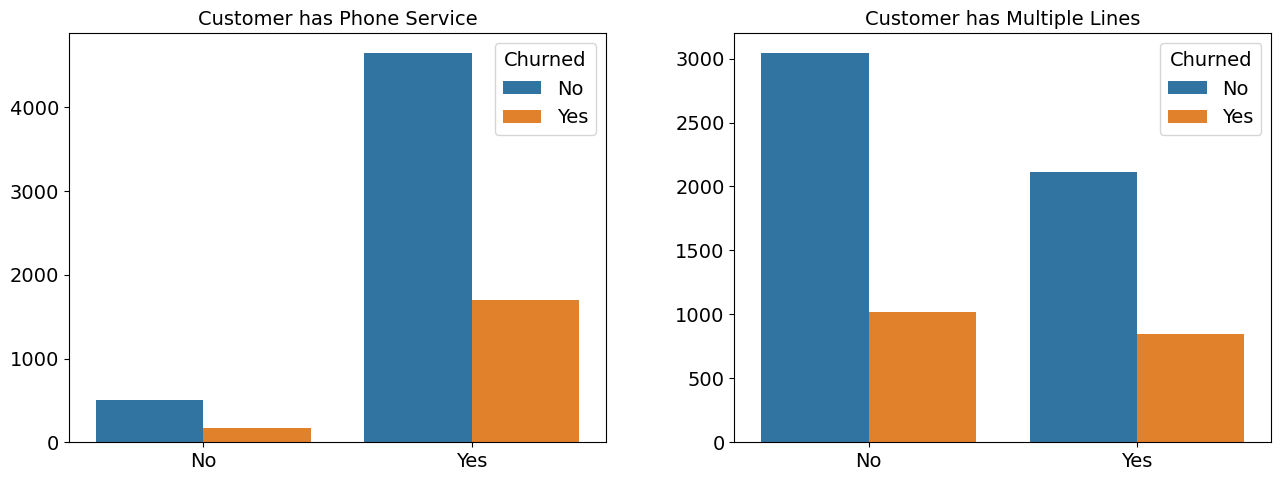

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), dpi=100)

sns.countplot(x='PhoneService', hue='Churn', data=df, ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0].set_title('Customer has Phone Service', fontsize=14)

sns.countplot(x=df['MultipleLines_yn'], hue='Churn', data=df, ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1].set_title('Customer has Multiple Lines', fontsize=14)

fig.tight_layout(pad=5)
fig.show()

- Phone service and multiple lines don't seem to affect whether a customer will churn

##### *Plot extra services*

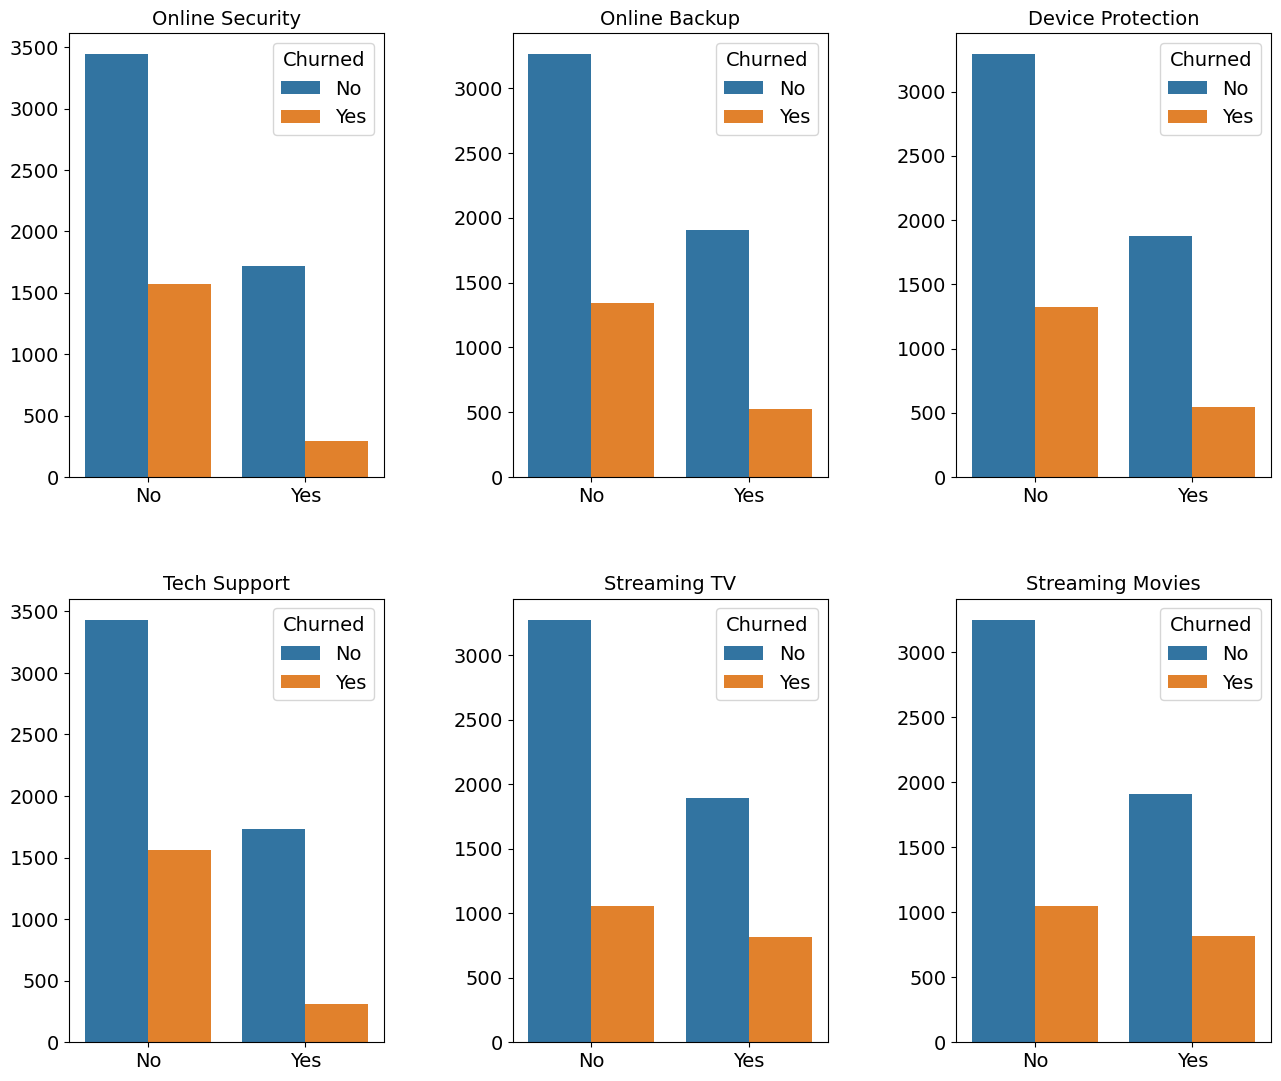

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(14,12), dpi=100)

sns.countplot(x='OnlineSecurity_yn', hue='Churn', data=df, ax=ax[0,0])
ax[0,0].set_xlabel(None)
ax[0,0].set_ylabel(None)
ax[0,0].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0,0].tick_params(axis='both', which='major', labelsize=14)
ax[0,0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,0].set_title('Online Security', fontsize=14)

sns.countplot(x='OnlineBackup_yn', hue='Churn', data=df, ax=ax[0,1])
ax[0,1].set_xlabel(None)
ax[0,1].set_ylabel(None)
ax[0,1].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0,1].tick_params(axis='both', which='major', labelsize=14)
ax[0,1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,1].set_title('Online Backup', fontsize=14)

sns.countplot(x='DeviceProtection_yn', hue='Churn', data=df, ax=ax[0,2])
ax[0,2].set_xlabel(None)
ax[0,2].set_ylabel(None)
ax[0,2].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0,2].tick_params(axis='both', which='major', labelsize=14)
ax[0,2].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,2].set_title('Device Protection', fontsize=14)

sns.countplot(x='TechSupport_yn', hue='Churn', data=df, ax=ax[1,0])
ax[1,0].set_xlabel(None)
ax[1,0].set_ylabel(None)
ax[1,0].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1,0].tick_params(axis='both', which='major', labelsize=14)
ax[1,0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,0].set_title('Tech Support', fontsize=14)

sns.countplot(x='StreamingTV_yn', hue='Churn', data=df, ax=ax[1,1])
ax[1,1].set_xlabel(None)
ax[1,1].set_ylabel(None)
ax[1,1].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1,1].tick_params(axis='both', which='major', labelsize=14)
ax[1,1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,1].set_title('Streaming TV', fontsize=14)

sns.countplot(x='StreamingMovies_yn', hue='Churn', data=df, ax=ax[1,2])
ax[1,2].set_xlabel(None)
ax[1,2].set_ylabel(None)
ax[1,2].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1,2].tick_params(axis='both', which='major', labelsize=14)
ax[1,2].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,2].set_title('Streaming Movies', fontsize=14)

fig.tight_layout(pad=5)
fig.show()

- Customers without online security and/or tech support services are more likely to churn

##### *Plot contract types*

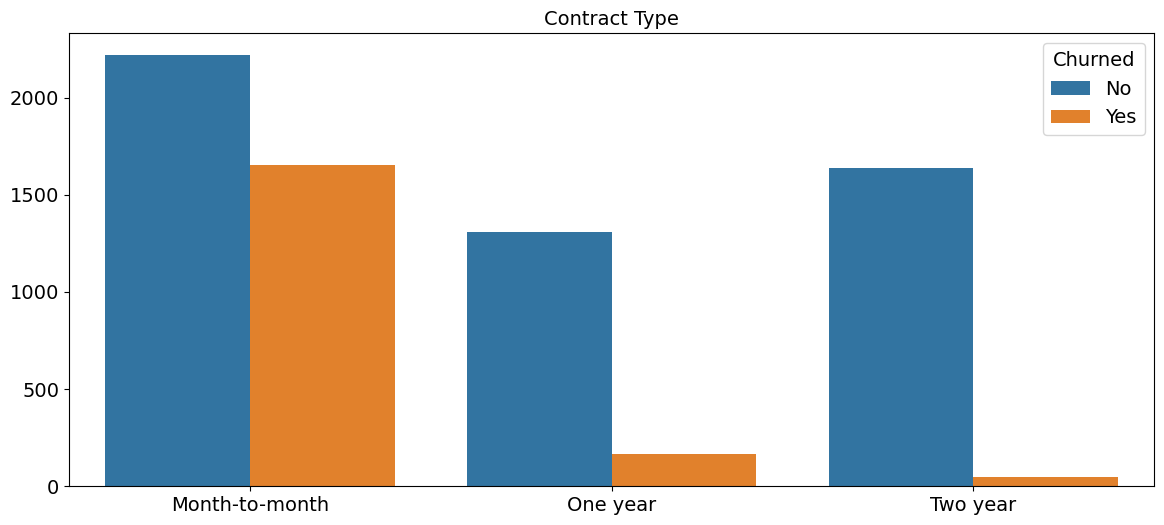

In [29]:
plt.figure(figsize=(14,6), dpi=100, facecolor='white')
sns.countplot(x='Contract', hue='Churn', data=df)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
plt.title('Contract Type', fontsize=14)
plt.savefig('./images/contract_types.svg')
plt.show()

- Customers with short-term contracts (monthly-to-month) are more likely to churn

##### *Plot number of customers based on tenure and contract type*

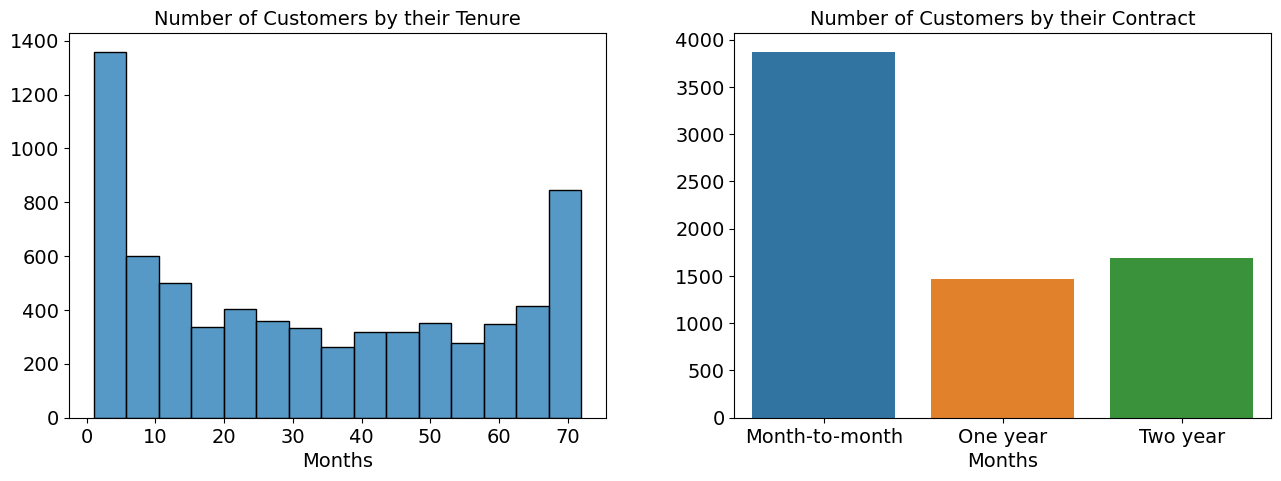

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), dpi=100, facecolor='white')

sns.histplot(df['tenure'], ax=ax[0])
ax[0].set_xlabel('Months', fontsize=14)
ax[0].set_ylabel(None)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Number of Customers by their Tenure', fontsize=14)

sns.countplot(x=df['Contract'], ax=ax[1])
ax[1].set_xlabel('Months', fontsize=14)
ax[1].set_ylabel(None)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title('Number of Customers by their Contract', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/no_customers_by.svg')
fig.show()

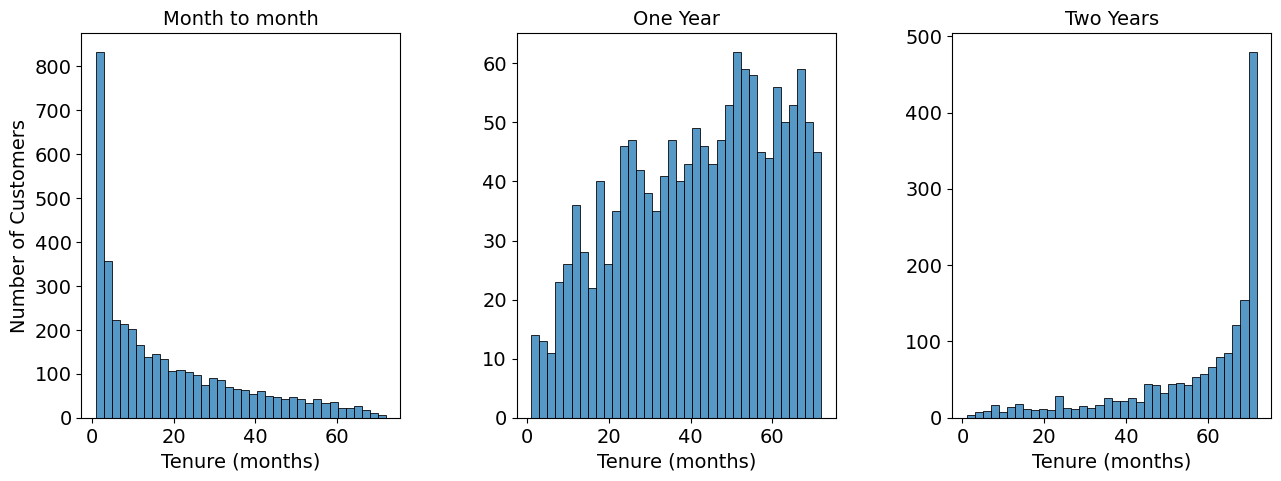

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(14,6), dpi=100, facecolor='white')

sns.histplot(df[df['Contract']=='Month-to-month']['tenure'], bins=36, ax=ax[0])
ax[0].set_xlabel('Tenure (months)', fontsize=14)
ax[0].set_ylabel('Number of Customers', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Month to month', fontsize=14)

sns.histplot(df[df['Contract']=='One year']['tenure'], bins=36, ax=ax[1])
ax[1].set_xlabel('Tenure (months)', fontsize=14)
ax[1].set_ylabel(None)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title('One Year', fontsize=14)

sns.histplot(df[df['Contract']=='Two year']['tenure'], bins=36, ax=ax[2])
ax[2].set_xlabel('Tenure (months)', fontsize=14)
ax[2].set_ylabel(None)
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_title('Two Years', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/no_customers_by_tenure.svg')
fig.show()

- Most of the monthly contracts last between 1-2 months
- Most of the 2-year contracts last more than 5 years in total
- In general, customers with longer contracts seem to be more loyal

##### *Plot payment methods*

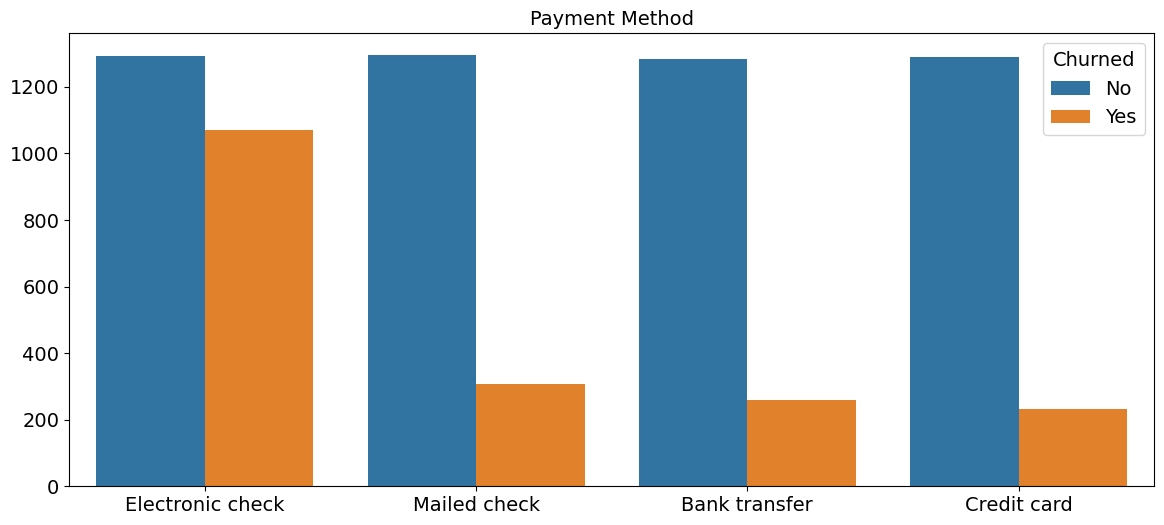

In [32]:
plt.figure(figsize=(14,6), dpi=100)
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
plt.title('Payment Method', fontsize=14)
plt.show()

- According to the graph, the prefered payment method among customers is electronic check
- Also the customers who use electronic check are more likely to churn

**Key Findings**

- Approximately 1 out of 4 customers left the company within the last month
- Non-senior customers and customers who don't have partners or dependents are more likely to churn
- Recent customers (smaller tenure) and customers with short-term contracts (monthly-to-month) are more likely to churn
- Moreover, clients with higher monthly charges are prone to churn
- Even though electronic check is the preferred payment method, customers using electronic check are more likely to churn

## Data Preprocessing <a class='anchor' id='data_preprocessing'></a>

- First, we need to choose the columns with which we want to proceed

##### *Choose relevant columns*

In [33]:
# choose columns
cols = np.r_[1:7, 15:20, 21:32, 20]

# final df
df = df.iloc[:, cols]

In [34]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,auto_PaymentMethod,InternetService_yn,DSL_yn,Fiber_yn,MultipleLines_yn,OnlineSecurity_yn,OnlineBackup_yn,DeviceProtection_yn,TechSupport_yn,StreamingTV_yn,StreamingMovies_yn,Churn
0,Female,0,Yes,No,1,No,Month-to-month,Yes,Electronic check,29.85,29.850000,0,1,1,0,0,0,1,0,0,0,0,0
1,Male,0,No,No,34,Yes,One year,No,Mailed check,56.95,1889.500000,0,1,1,0,0,1,0,1,0,0,0,0
2,Male,0,No,No,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.150002,0,1,1,0,0,1,1,0,0,0,0,1
3,Male,0,No,No,45,No,One year,No,Bank transfer,42.30,1840.750000,1,1,1,0,0,1,0,1,1,0,0,0
4,Female,0,No,No,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.649994,0,1,0,1,0,0,0,0,0,0,0,1


### *One-Hot Encoding* <a class='anchor' id='ohe'></a>

In [35]:
# get dummy variables
df = pd.get_dummies(df, drop_first=False)

# columns
df.columns = df.columns.str.replace(' ', '_').str.replace('-','_')

In [36]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,auto_PaymentMethod,InternetService_yn,DSL_yn,Fiber_yn,MultipleLines_yn,OnlineSecurity_yn,OnlineBackup_yn,DeviceProtection_yn,TechSupport_yn,StreamingTV_yn,StreamingMovies_yn,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer,PaymentMethod_Credit_card,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.850000,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.500000,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.150002,0,1,1,0,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.750000,1,1,1,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.649994,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0


### *Train Test Split* <a class='anchor' id='train_test_split'></a>

In [37]:
# define x, y
x = df.drop(columns='Churn')
y = df.Churn

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

## Feature Engineering <a class='anchor' id='feature_engineering'></a>

### *Feature Transformation* <a class='anchor' id='feature_transformation'></a>

- Feature transformation is a mathematical transformation in which we apply a mathematical formula to a particular column
- In our case, we will transform the values of the `TotalCharges` column using box-cox
- The reason is that its values have currently a very high variance which will affect our analysis and predictions

##### *Check current `TotalCharges` distribution in `x_train` and `x_test`*

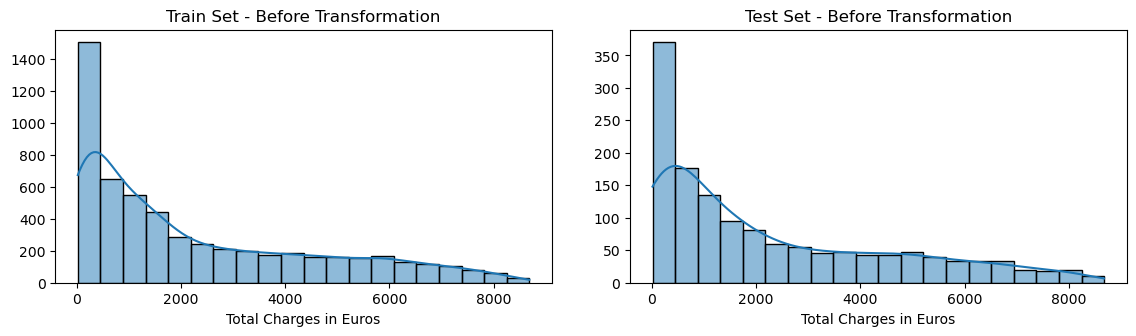

In [38]:
# create figure
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=100)
    
# plot histogram
sns.histplot(x_train.TotalCharges, kde=True, bins=20, ax=ax[0])
ax[0].set_xlabel('Total Charges in Euros')
ax[0].set_ylabel(None)    
ax[0].set_title('Train Set - Before Transformation')

sns.histplot(x_test.TotalCharges, kde=True, bins=20, ax=ax[1])
ax[1].set_xlabel('Total Charges in Euros')
ax[1].set_ylabel(None)    
ax[1].set_title('Test Set - Before Transformation')

fig.tight_layout(pad=3)
fig.show()

##### *Transform `TotalCharges` in `x_train` and `x_test`*

In [39]:
# feature to transform
to_transform = 'TotalCharges'

# transform using box-cox
x_train[to_transform], best_lambda = boxcox(x_train[to_transform], lmbda=None)
x_test[to_transform] = boxcox(x_test[to_transform], lmbda=best_lambda)

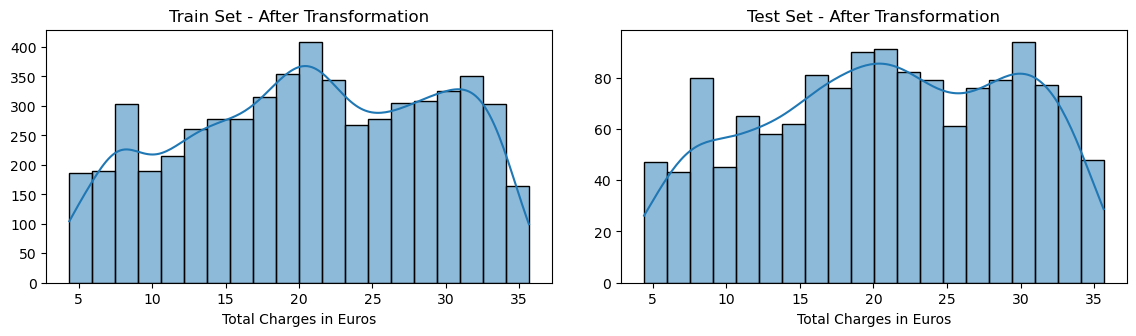

In [40]:
# create figure
fig, ax = plt.subplots(1, 2, figsize=(12,4), dpi=100)
    
# plot histogram
sns.histplot(x_train.TotalCharges, kde=True, bins=20, ax=ax[0])
ax[0].set_xlabel('Total Charges in Euros')
ax[0].set_ylabel(None)    
ax[0].set_title('Train Set - After Transformation')

sns.histplot(x_test.TotalCharges, kde=True, bins=20,ax=ax[1])
ax[1].set_xlabel('Total Charges in Euros')
ax[1].set_ylabel(None)    
ax[1].set_title('Test Set - After Transformation')

fig.tight_layout(pad=3)
fig.show()

### *Feature Scaling* <a class='anchor' id='feature_scaling'></a>

- Some machine learning algorithms will not work properly if the range of values of the data varies widely
- *Feature Scaling* is a method used to normalize the range of independent variables of the data
- Most of the features in our dataset are already normalized, but for those that are not we need to apply scaling

##### *Get the features that need to be scaled*

In [41]:
# get the features that need scaling
to_scale = [feature for feature in x_train.columns if (df[feature].max() > 1)]

# features to scale
print(f'Features to scale: {to_scale}')

Features to scale: ['tenure', 'MonthlyCharges', 'TotalCharges']


- Now that we have obtained the features, we need to decide what technique we should use to scale them
- In order to have a better understanding on that, let's have a look at their distributions
- Depending whether or not they follow a normal distribution, we will choose the appropriate scaler

##### *Create a function to visualize the distribution of non-normalized features*

In [42]:
def plot_distribution(df, i, feature):
    """
    1. Calculate feature skewness
    2. Run Shapiro Wilk test on a sample to test normality hypothesis
    3. Plot feature distribution
    """
    
    # calculate skewnees
    skewness = df[feature].skew()
    
    # select a sample of 1000 data points
    sample = df[feature].sample(n=1000, random_state=1)
    # test for normal distribution
    shapiro_wilk = shapiro(sample)
    norm_distrib = ('True' if shapiro_wilk.pvalue > 0.05 else 'False')
    
    # print results
    print(f'# {i+1} - {feature}')
    print('='*117)
    print(f'Skewness: {skewness}')
    print('-'*117)
    print(f'Shapiro Wilk test: {shapiro_wilk}')
    print('-'*117)
    print(f'Normal Distribution: {norm_distrib}')
    print('='*117)
    
    # create figure
    plt.figure(figsize=(12,4), dpi=100)
    
    # plot histogram
    sns.histplot(df[feature], kde=True)
    
    # params
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f'{feature} distribution', fontsize=14)
    
    plt.tight_layout(pad=3)
    plt.show()
    
    return None

##### *Shapiro-Wilk Normality Test*

- We will use Shapiro-Wilk test to detect if the population of the features that are being tested is normally distributed

*Hypothesis Testing*
- **Null Hypothesis (H0):** The sample (obtained from `feature_name`) comes from a normal distribution
- **Alternative Hypothesis (H1):** The sample (obtained from `feature_name`) does not come from a normal distribution

*Results*
- We **reject** the Null Hypothesis (H0) if p-value < 0.05

# 1 - tenure
Skewness: 0.24140026684019025
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.8960144519805908, pvalue=1.8921790235954206e-25)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


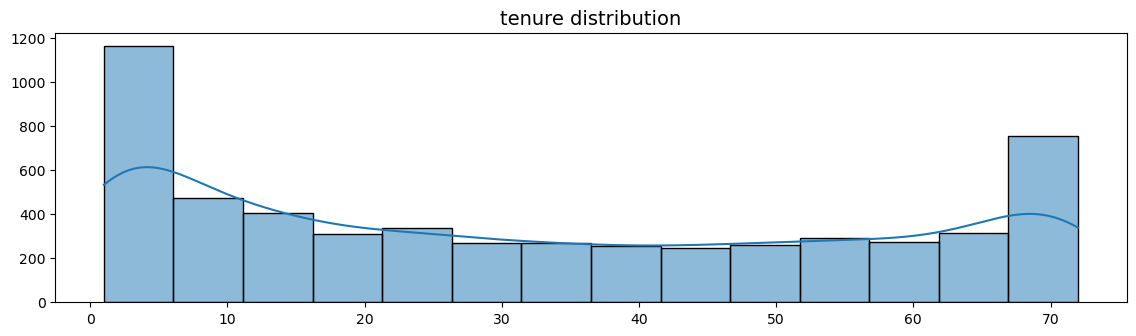

# 2 - MonthlyCharges
Skewness: -0.22500832854581657
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9249390363693237, pvalue=6.334159269560838e-22)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


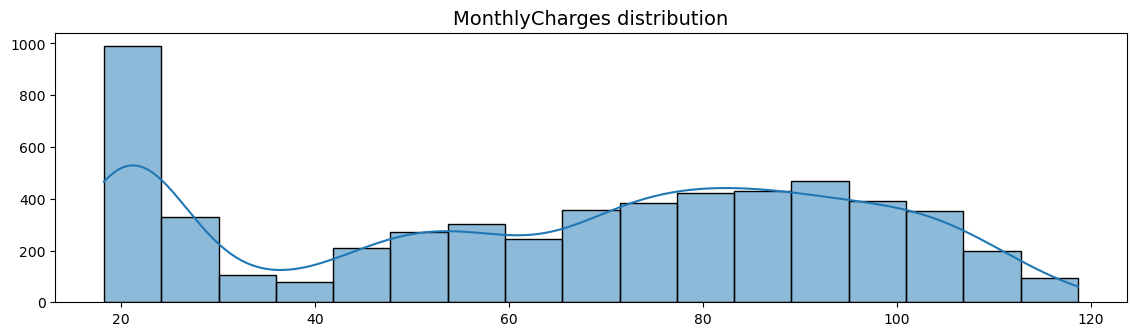

# 3 - TotalCharges
Skewness: -0.1457083523273468
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9625574350357056, pvalue=2.4373629284709037e-15)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


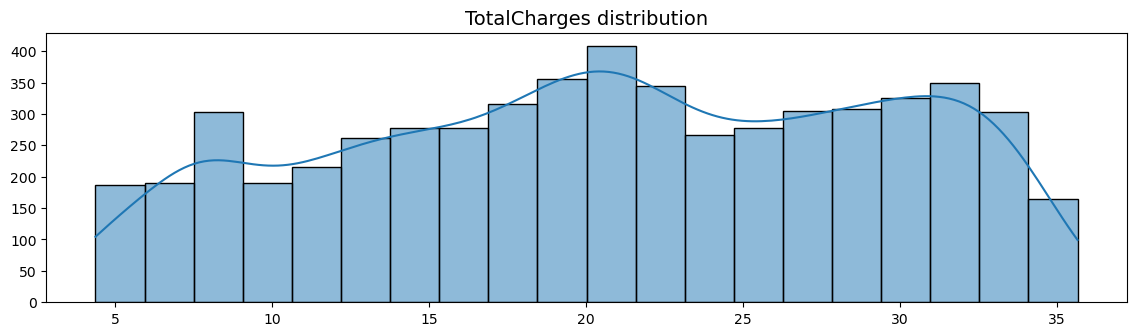

In [43]:
_ = [plot_distribution(x_train, i, feature) for i, feature in enumerate(to_scale)]

- According to the graphs, none of the features seems to follow a normal distribution
- Moreover, the *p-value* obtained from the Shapiro-Wilk test is less than 5%, indicating that none of the samples tested comes from a normal distribution
- Therefore, we **reject** the null hypothesis
- As a result of the previous test, we will scale these features using `MinMaxScaler`

##### *Scale using `MinMaxScaler`*

In [44]:
# initialise scaler
mms = MinMaxScaler()

# scale train and test data
x_train[to_scale] = mms.fit_transform(x_train[to_scale])
x_test[to_scale] = mms.transform(x_test[to_scale])

### *Handle Class Imbalance* <a class='anchor' id='handle_class_imbalance'></a>

In [45]:
y_train.value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

- We knew that our dataset is highly imbalanced
- In order to handle that, we will use an over-sampling algorithm, called `SMOTE`

##### *Generate new synthetic samples using `SMOTE`*

In [46]:
# initialise 
smo = SMOTE(random_state=1)

# fit and resample x_train and y_train
xb_train, yb_train = smo.fit_resample(x_train, y_train)

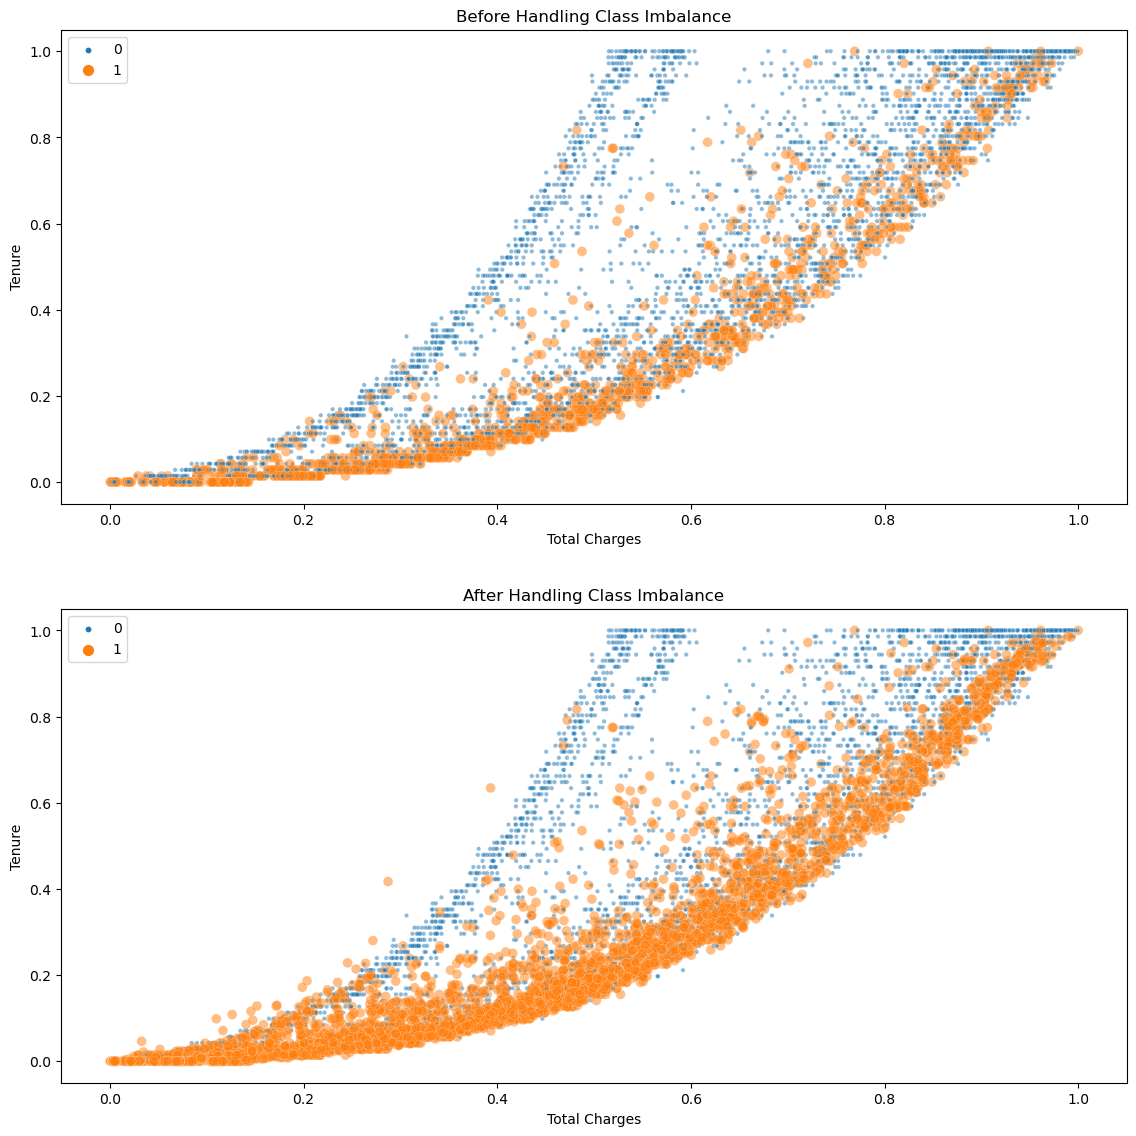

In [47]:
fig, ax = plt.subplots(2,1,figsize=(12,12), dpi=100, facecolor='white')

sns.scatterplot(x=x_train.TotalCharges, y=x_train.tenure, hue=y_train.values, size=y_train.values, sizes=[10,50], alpha=0.5, ax=ax[0])
ax[0].set_xlabel('Total Charges')
ax[0].set_ylabel('Tenure')
ax[0].set_title('Before Handling Class Imbalance')

sns.scatterplot(x=xb_train.TotalCharges, y=xb_train.tenure, hue=yb_train.values, size=yb_train.values, sizes=[10,50], alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Total Charges')
ax[1].set_ylabel('Tenure')
ax[1].set_title('After Handling Class Imbalance')

fig.tight_layout(pad=3)
fig.savefig('./images/class_imbalance_prior_post_smote.svg')
fig.show()

## Modeling <a class='anchor' id='modeling'></a>

### *Cross Validation* <a class='anchor' id='cross_validation'></a>

##### *Function to cross validate multiple models*

In [48]:
def cross_validate_models(x_train, y_train):
    
    # create a list of classifiers
    models = [['LogisticRegression', LogisticRegression(solver='liblinear',random_state=1)],
              ['SVC', SVC(random_state=1)],
              ['KNN', KNeighborsClassifier()],
              ['RandomForest', RandomForestClassifier(random_state=1)],
              ['LightGBM', LGBMClassifier(random_state=1)]]

    # create a dataframe to store the results
    index = [model[0] for model in models]
    columns = ['Precision', 'Recall', 'F1 Score', 'ROC', 'Accuracy']
    cv_scores = pd.DataFrame(np.nan, index=index, columns=columns)

    # loop through classifiers
    for name, model in models:

        # cross validate
        scoring = ['precision', 'recall', 'f1', 'roc_auc', 'accuracy']
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        scores = cross_validate(model, x_train, y_train, scoring=scoring, cv=cv, error_score="raise")

        # evaluate
        avg_precision = scores['test_precision'].mean()
        avg_recall = scores['test_recall'].mean()
        avg_f1 = scores['test_f1'].mean()
        avg_roc = scores['test_roc_auc'].mean()
        avg_accuracy = scores['test_accuracy'].mean()
        
        # print results
        # print('='*30)
        # print(f'{name}')
        # print('-'*30)
        # print(f'Precision: {avg_precision}')
        # print(f'Recall:    {avg_recall}')
        # print(f'F1 Score:  {avg_f1}')
        # print(f'ROC:       {avg_roc}')
        # print(f'Accuracy:  {avg_accuracy}\n')
        
        # store results
        cv_scores.loc[name, 'Precision'] = avg_precision
        cv_scores.loc[name, 'Recall'] = avg_recall
        cv_scores.loc[name, 'F1 Score'] = avg_f1
        cv_scores.loc[name, 'ROC'] = avg_roc
        cv_scores.loc[name, 'Accuracy'] = avg_accuracy

    return cv_scores

# set starting time
start_time = datetime.now()

# run function to get the results
cv_scores = cross_validate_models(xb_train, yb_train)

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

Running time: 0:00:16.833620


In [49]:
# print results
print(cv_scores.sort_values(by='F1 Score', ascending=False))

                    Precision    Recall  F1 Score       ROC  Accuracy
RandomForest         0.827055  0.871913  0.848889  0.918451  0.844794
LightGBM             0.821455  0.867797  0.843984  0.921598  0.839588
SVC                  0.807969  0.857627  0.832016  0.905478  0.826877
KNN                  0.768713  0.900484  0.829376  0.879343  0.814770
LogisticRegression   0.808305  0.851332  0.829256  0.907846  0.824697


### *GridSearchCV* <a class='anchor' id='grid_search_cv'></a>

##### *Function to find the best hyperparameters*

In [50]:
def grid_search_tuning_models(x_train, y_train):
    
    # create a list of classifiers
    models = [['LogisticRegression', LogisticRegression(random_state=1)],
              ['SVC', SVC(random_state=1)],
              ['KNN', KNeighborsClassifier()],
              ['RandomForest', RandomForestClassifier(random_state=1)],
              ['LightGBM', LGBMClassifier(random_state=1)]]
    
    # create a list of hyperparameters
    params = [['LogisticRegression', {'penalty': ['l1','l2'], 'solver': ['liblinear','sag','saga'], 'max_iter': range(100,600,100)}],
              ['SVC', {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
              ['KNN', {'n_neighbors': range(20,120,20), 'weights': ['uniform','distance'], 'metric': ['euclidean','manhattan','minkowski']}],
              ['RandomForest', {'n_estimators': range(100,1300,300), 'criterion': ['gini','entropy']}],
              ['LightGBM', {'n_estimators': range(100,1300,300)}]]
    

    # create a dataframe to store the results
    gs_scores = pd.DataFrame(np.nan, index=[model[0] for model in models], columns=['Recall'])

    # loop through classifiers
    for index, model in enumerate(models):
        
        # gridsearchCV
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        grid = GridSearchCV(model[1], params[index][1], scoring='f1', cv=cv)
        grid.fit(x_train, y_train)
        
        # evaluate
        best_score = grid.best_score_
        best_params = grid.best_params_
        best_estimator = grid.best_estimator_
        
        # print results
        print('='*94)
        print(f'{model[0]}')
        print('-'*94)
        print(f'Best grid score: {best_score}')
        print(f'Best grid params: {best_params}')
        print(f'Best estimator: {best_estimator}', end='\n\n')
        
        # store results
        gs_scores.loc[model[0], 'Recall'] = best_score

    return gs_scores

# set starting time
start_time = datetime.now()

# run function to get the results
gs_scores = grid_search_tuning_models(xb_train, yb_train)

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

LogisticRegression
----------------------------------------------------------------------------------------------
Best grid score: 0.8404448734990311
Best grid params: {'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best estimator: LogisticRegression(penalty='l1', random_state=1, solver='saga')

SVC
----------------------------------------------------------------------------------------------
Best grid score: 0.8386364082886827
Best grid params: {'kernel': 'poly'}
Best estimator: SVC(kernel='poly', random_state=1)

KNN
----------------------------------------------------------------------------------------------
Best grid score: 0.8239317293222459
Best grid params: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance')

RandomForest
----------------------------------------------------------------------------------------------
Best grid score: 0.8514824260738264
Best grid params:

### *Predictions (on test set)* <a class='anchor' id='predictions'></a>

##### *Function to make predictions on test set*

In [51]:
def make_predictions(x_train, x_test, y_train, y_test):

    # create a list of the best performing classifiers
    models = [['LogisticRegression', LogisticRegression(penalty='l1', random_state=1, solver='saga')],
              ['SVC', SVC(kernel='poly', random_state=1)],
              ['KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance')],
              ['RandomForest', RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=1)],
              ['LightGBM', LGBMClassifier(n_estimators=400, random_state=1)]]

    # create a dataframe to store the results
    index=[model[0] for model in models]
    columns=['Precision', 'Recall', 'F1 Score', 'ROC', 'Accuracy']
    prediction_scores = pd.DataFrame(np.nan, index=index, columns=columns)
    
    # loop through classifiers
    for name, model in models:
        
        # fit and predict
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        
        # evaluate
        preds = model.predict(x_test)
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        roc = roc_auc_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        
        # print results
        print('='*53)
        print(f'{name}')
        print('-'*53)
        # print(f'Precision: {precision}')
        # print(f'Recall:    {recall}')
        # print(f'F1 Score:  {f1}')
        # print(f'ROC:       {roc}')
        # print(f'Accuracy:  {accuracy}')
        # print(f'{confusion_matrix(y_test, preds)}')
        print(f'True Positives:  {tp}')
        print(f'True Negatives:  {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print('-'*53)
        print(f'{classification_report(y_test, preds)}')
        
        # store results
        prediction_scores.loc[name, 'Precision'] = precision
        prediction_scores.loc[name, 'Recall'] = recall
        prediction_scores.loc[name, 'F1 Score'] = f1
        prediction_scores.loc[name, 'ROC'] = roc
        prediction_scores.loc[name, 'Accuracy'] = accuracy

    return prediction_scores

# set starting time
start_time = datetime.now()

# run final predictions
predictions = make_predictions(xb_train, x_test, yb_train, y_test)

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

LogisticRegression
-----------------------------------------------------
True Positives:  251
True Negatives:  865
False Positives: 168
False Negatives: 123
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1033
           1       0.60      0.67      0.63       374

    accuracy                           0.79      1407
   macro avg       0.74      0.75      0.74      1407
weighted avg       0.80      0.79      0.80      1407

SVC
-----------------------------------------------------
True Positives:  243
True Negatives:  824
False Positives: 209
False Negatives: 131
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1033
           1       0.54      0.65      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71     

In [52]:
# print results
print(predictions.sort_values(by='F1 Score', ascending=False))

                    Precision    Recall  F1 Score       ROC  Accuracy
LogisticRegression   0.599045  0.671123  0.633039  0.754245  0.793177
SVC                  0.537611  0.649733  0.588378  0.723705  0.758351
RandomForest         0.539683  0.636364  0.584049  0.719924  0.759062
LightGBM             0.547619  0.614973  0.579345  0.715521  0.762615
KNN                  0.443144  0.708556  0.545267  0.693097  0.685856


## Conclusion <a class='anchor' id='conclusion'></a>

What is the best model? To answer this, let's try to understand some of the metrics in our case.

**Precision:** How many of the predicted customers had actually churned?  
**Recall:** How many of the customers that had actually churned the model predicted right?  
**F1 Score:** The harmonic mean of precision and recall.

<p style='text-align: justify;'>
    Since <b>Logistic Regression</b> has the highest f1 score, it has the best overall performance and theregore provides the right trade-off between precision and recall. However, if the company wants to choose a model to deploy in the real world, it will have to make a trade-off between the amount of revenue it wants to retain and the amount of revenue it is willing to spend on customer retention programs. This trade-off, is the result of the trade-off between precision and recall.
</p>

<p style='text-align: justify;'>
Therefore, if the company wants to retain more revenue, it should choose a model with <i>higher recall</i> - and lower precision - such as <b>K-Nearest Neighbors</b>. This will result in <i>higher false positives</i>, which will cause the company to include customers who will not churn in its retention programs and increase its spending. However, if the company decides to retain a decent amount of revenue without spending a lot on retention programs, then it should choose a model with <i>higher f1 score</i>. In this case, <b>Logistic Regression</b> would be the best choice.
</p>

---

*Thank you!*

---